In [ ]:
%pip install pandas
%pip install numpy

In [87]:
import pandas as pd
file = open("..\peni\Left\peni_LeftHand_Coordinates.csv", 'r')
df = pd.read_csv(file)
file.close()

In [192]:
import numpy as np
file_kms = open("..\pain\Right\pain_RightHand_Coordinates.csv", 'r')
df_pain = pd.read_csv(file_kms)
file_kms.close()
np_coords_pain = np.reshape(df_pain.iloc[-1].to_numpy(), [1, -1])
list_coords_pain = list(np_coords_pain)
parsed_list_pain = []
for i in range(len(list_coords_pain[0])):
    parsed_list_pain.append(str(list_coords_pain[0][i]).strip('()').split(','))
parsed_array_pain = np.array(parsed_list_pain[0:21], dtype = np.float32)

In [88]:
np_coords = df.to_numpy()
list_coords = list(np_coords)

In [89]:
parsed_list = []
for i in range(len(list_coords[0])):
    parsed_list.append(str(list_coords[0][i]).strip('()').split(','))

In [601]:
from itertools import combinations
landmarks = np.arange(21)
combos = np.array(list(combinations(landmarks, 3)))
def joint_angles_fast(coords, combos):
    vecA = np.subtract(coords[combos[:, 1], :], coords[combos[:, 0], :])
    vecB = np.subtract(coords[combos[:, 1], :], coords[combos[:, 2], :])
    X = np.einsum('ij, ij -> i', vecA, vecB)/np.linalg.norm(vecA, 2, 1)/np.linalg.norm(vecB, 2, 1)
    Y = np.linalg.norm(np.cross(vecA, vecB), 2, 1)/np.linalg.norm(vecA, 2, 1)/np.linalg.norm(vecB, 2, 1)
    angles = np.arctan2(Y, X)
    return angles

In [200]:
true_angles = joint_angles_fast(parsed_array, combos)

In [642]:
#Attempt to do reconstruction using only the angles, using my hand as a starting point
#We know the angles for sure

# By rodrigues angle formula:
def reconstruction(angles, landmark_array, combos):
    for j in range(1330):
        i = 1329 - j
        vecA = np.subtract(landmark_array[combos[i, 1], :], landmark_array[combos[i, 0], :])
        vecB = np.subtract(landmark_array[combos[i, 1], :], landmark_array[combos[i, 2], :])
        theta = angles[i] - true_angles[i]
        k = np.cross(vecA, vecB)
        k = k / np.linalg.norm(k)
        vecB_new = vecB * np.cos(theta) + np.cross(k, vecB) * np.sin(theta) + k * np.dot(k, vecB)* (1-np.cos(theta))
        landmark_array[combos[i, 2], :] = landmark_array[combos[i, 1], :] + vecB_new
    return landmark_array

In [106]:
pca_df = pd.read_csv('nmf_basis.csv')
pca_basis = pca_df.to_numpy()

In [107]:
example_vec = pca_basis[:, 0]

In [647]:
import numpy as np
# given the original landmarks of my neutral gesture hand (parsed_array)
# Want to generate landmark array s.t. the angles of landmark array correspond to my input angles given in example_vec
parsed_array = np.array(parsed_list[0:21], dtype = np.float32)
temp = parsed_array
# parsed_array = temp
angles = pain_angles


In [ ]:
# given the original landmarks of my neutral gesture hand (parsed_array)
# Want to generate landmark array s.t. the angles of landmark array correspond to my input angles given in example_vec

for j in range(1330):
    i = 1329- j
    print(temp)
    p_0 = np.concatenate((temp[combos[i, 0], :], [1]))
    p_1 = np.concatenate((temp[combos[i, 1], :], [1]))
    p_2 = np.concatenate((temp[combos[i, 2], :], [1]))
    
    vec01 = p_0 - p_1
    vec12 = p_1 - p_2
    rot_axis_vec = np.cross(vec01[0:3], vec12[0:3])
    rot_axis_vec = rot_axis_vec/np.linalg.norm(rot_axis_vec)
    rot_origin = p_1[0:3] - rot_axis_vec
    #translate onto origin
    t_mat = np.array([
        [1, 0, 0, -rot_origin[0]],
        [0, 1, 0, -rot_origin[1]], 
        [0, 0, 1, -rot_origin[2]],
        [0, 0, 0, 1] 
    ], dtype = np.float32)
    t_mat_inv = np.array([
        [1, 0, 0, rot_origin[0]],
        [0, 1, 0, rot_origin[1]], 
        [0, 0, 1, rot_origin[2]],
        [0, 0, 0, 1] 
    ], dtype = np.float32)
    a = rot_axis_vec[0]
    b = rot_axis_vec[1]
    c = rot_axis_vec[2]
    d = np.sqrt(b**2 + c**2)
    r_x = np.array([
        [1, 0, 0, 0], 
        [0, c/d, -b/d, 0],
        [0, b/d, c/d, 0],
        [0, 0, 0, 1]
    ], dtype = np.float32)
    r_x_inv = np.array([
        [1, 0, 0, 0], 
        [0, c/d, b/d, 0],
        [0, -b/d, c/d, 0],
        [0, 0, 0, 1]
    ], dtype = np.float32)
    r_y = np.array([
        [d, 0, -a, 0],
        [0, 1, 0, 0],
        [a, 0, d, 0], 
        [0, 0, 0, 1]
    ], dtype = np.float32)
    r_y_inv = np.array([
        [d, 0, a, 0],
        [0, 1, 0, 0],
        [-a, 0, d, 0], 
        [0, 0, 0, 1]
    ], dtype = np.float32)
    r_z = np.array([
        [np.cos(angles[i]-true_angles[i]), np.sin(angles[i]-true_angles[i]), 0, 0],
        [-np.sin(angles[i]-true_angles[i]), np.cos(angles[i]-true_angles[i]), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ], dtype = np.float32)

    p_new = t_mat_inv @ r_x_inv @ r_y_inv @ r_z @ r_y @ r_x @ t_mat @ p_2
    temp[combos[i, 2], :] = p_new[0:3] 
    # for coord_ind in range(combos[i, 0], 21):
    #     print(coord_ind)
    #     p = np.concatenate((temp[coord_ind, :], [1]))
    #     p_new = t_mat_inv @ r_x_inv @ r_y_inv @ r_z @ r_y @ r_x @ t_mat @ p
    #     temp[combos[coord_ind, 2], :] = p_new[0:3] 

temp_angles = joint_angles_fast(temp, combos)


In [604]:
pain_angles

array([3.0562305 , 2.9663582 , 2.7841315 , ..., 0.74503076, 1.1235361 ,
       1.6113212 ], dtype=float32)

In [662]:
example_coords = reconstruction(pain_angles, parsed_array, combos)
example_vec = joint_angles_fast(example_coords, combos)
print(example_vec)

[0.08536201 1.1668053  1.4312813  ... 2.5106401  0.7806388  0.65191543]


In [646]:
temp_angles

array([2.8750143, 2.258388 , 1.8657895, ..., 1.7801373, 2.4485226,
       2.787972 ], dtype=float32)

In [578]:
diff = temp_angles - pain_angles

In [18]:
from typing import List, Any, Dict, Tuple, Union
def draw_world_landmarks(
    plt: Any,
    ax_list: List[Any],
    landmark_array,
) -> None:
    ax_list[0].cla()
    # ax_list[0].set_xlim3d(-0.1, 0.1)
    # ax_list[0].set_ylim3d(-0.1, 0.1)
    # ax_list[0].set_zlim3d(-0.1, 0.1)
    ax_list[1].cla()
    # ax_list[1].set_xlim3d(-0.1, 0.1)
    # ax_list[1].set_ylim3d(-0.1, 0.1)
    # ax_list[1].set_zlim3d(-0.1, 0.1)
    handedness_index = 0
    # for handedness, _, hand_world_landmarks in zip(
    #         detection_result.handedness,
    #         detection_result.hand_landmarks,
    #         detection_result.hand_world_landmarks,
    # ):
    #     handedness_index: int = 0
    #     if handedness[0].display_name == 'Left':
    #         handedness_index = 0
    #     elif handedness[0].display_name == 'Right':
    #         handedness_index = 1

    # 各ランドマーク情報整理
    landmark_dict: Dict[int, List[float]] = {}
    for index in range(landmark_array.shape[0]):
        landmark_dict[index] = landmark_array[index, :]

    palm_list: List[int] = [0, 1, 5, 9, 13, 17, 0]
    thumb_list: List[int] = [1, 2, 3, 4]
    index_finger_list: List[int] = [5, 6, 7, 8]
    middle_finger_list: List[int] = [9, 10, 11, 12]
    ring_finger_list: List[int] = [13, 14, 15, 16]
    pinky_list: List[int] = [17, 18, 19, 20]

    # 掌
    palm_x, palm_y, palm_z = [], [], []
    for index in palm_list:
        point = landmark_dict[index]
        palm_x.append(point[0])
        palm_y.append(point[2])
        palm_z.append(point[1] * (-1))

    # 親指
    thumb_x, thumb_y, thumb_z = [], [], []
    for index in thumb_list:
        point = landmark_dict[index]
        thumb_x.append(point[0])
        thumb_y.append(point[2])
        thumb_z.append(point[1] * (-1))

    # 人差し指
    index_finger_x, index_finger_y, index_finger_z = [], [], []
    for index in index_finger_list:
        point = landmark_dict[index]
        index_finger_x.append(point[0])
        index_finger_y.append(point[2])
        index_finger_z.append(point[1] * (-1))

    # 中指
    middle_finger_x, middle_finger_y, middle_finger_z = [], [], []
    for index in middle_finger_list:
        point = landmark_dict[index]
        middle_finger_x.append(point[0])
        middle_finger_y.append(point[2])
        middle_finger_z.append(point[1] * (-1))

    # 薬指
    ring_finger_x, ring_finger_y, ring_finger_z = [], [], []
    for index in ring_finger_list:
        point = landmark_dict[index]
        ring_finger_x.append(point[0])
        ring_finger_y.append(point[2])
        ring_finger_z.append(point[1] * (-1))

    # 小指
    pinky_x, pinky_y, pinky_z = [], [], []
    for index in pinky_list:
        point = landmark_dict[index]
        pinky_x.append(point[0])
        pinky_y.append(point[2])
        pinky_z.append(point[1] * (-1))

    ax_list[handedness_index].plot(palm_x, palm_y, palm_z)
    ax_list[handedness_index].plot(thumb_x, thumb_y, thumb_z)
    ax_list[handedness_index].plot(index_finger_x, index_finger_y,
                                    index_finger_z)
    ax_list[handedness_index].plot(middle_finger_x, middle_finger_y,
                                    middle_finger_z)
    ax_list[handedness_index].plot(ring_finger_x, ring_finger_y,
                                    ring_finger_z)
    ax_list[handedness_index].plot(pinky_x, pinky_y, pinky_z)
    # ax_list[handedness_index].view_init(elev=180, azim=90)
    plt.pause(.001)

    return

In [16]:
%pip install ipympl --user

  Using cached ipympl-0.9.4-py3-none-any.whl (516 kB)
  Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl (26 kB)
  Using cached ipywidgets-8.1.5-py3-none-any.whl (139 kB)
  Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl (214 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python39\python.exe -m pip install --upgrade pip' command.


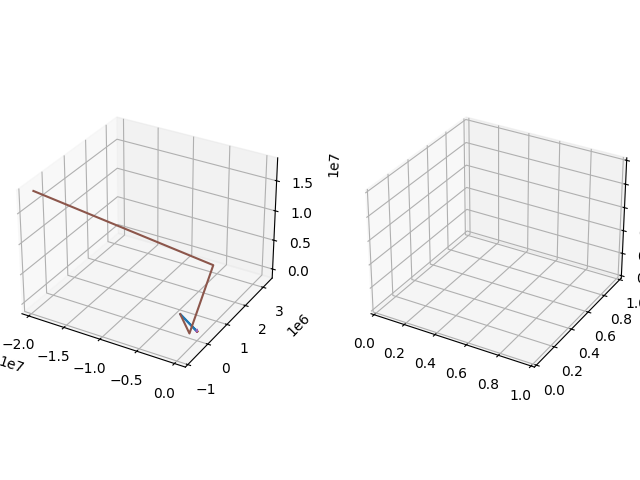

In [630]:
%matplotlib widget
import matplotlib.pyplot as plt
fig = plt.figure()
r_ax = fig.add_subplot(121, projection="3d")  # type:ignore
l_ax = fig.add_subplot(122, projection="3d")  # type:ignore
fig.subplots_adjust(left=0.0, right=1, bottom=0, top=1)
draw_world_landmarks(
    plt,
    [r_ax, l_ax],
    temp,
)